In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
from decode_fish.funcs.routines import *

import ipyvolume as ipv
from monai.inferers import sliding_window_inference

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

Load base config

In [4]:
early = load_tiff_image(base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/972503_early_infection.tif')
late = load_tiff_image(base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/972462_late_infection.tif')

In [58]:
from tifffile import imsave
imsave(base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/early.tif', data=cpu(early.transpose(0,1))[:1])
imsave(base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/date.tif', data=cpu(late.transpose(0,1))[:1])

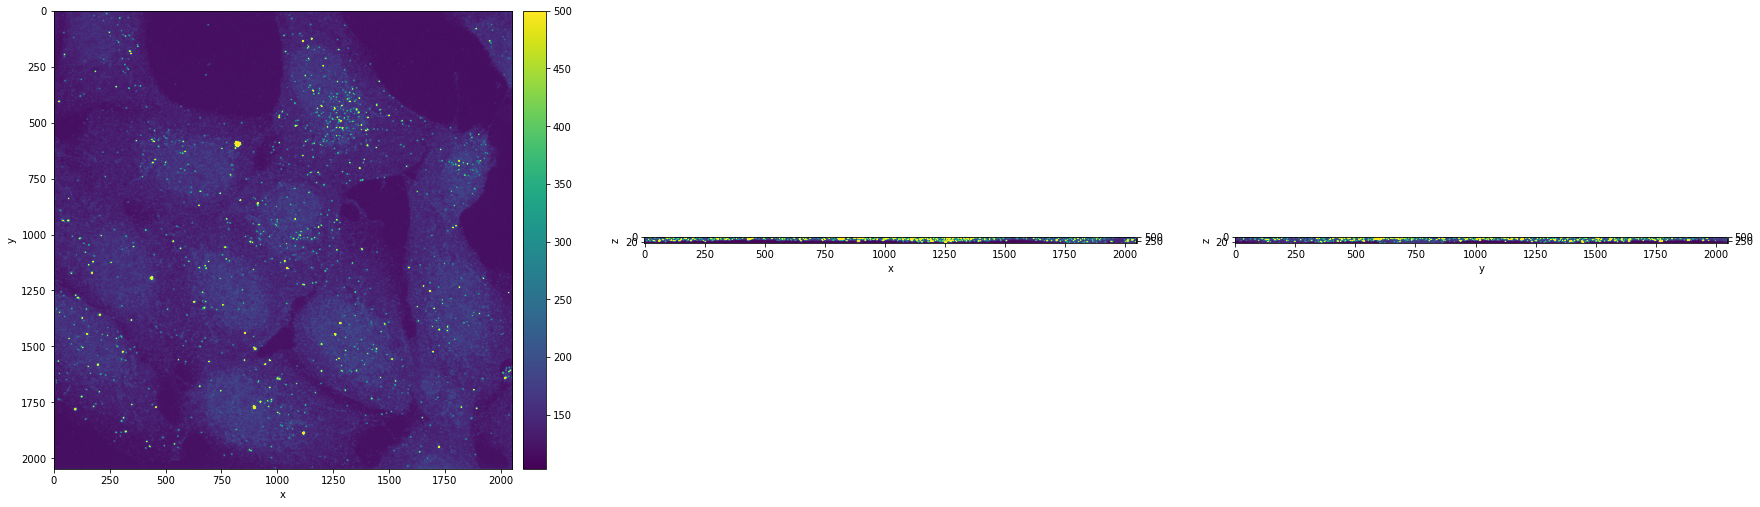

In [75]:
_ = plot_3d_projections(early[:,0,:,:], 'max', size=10, vmax=500)

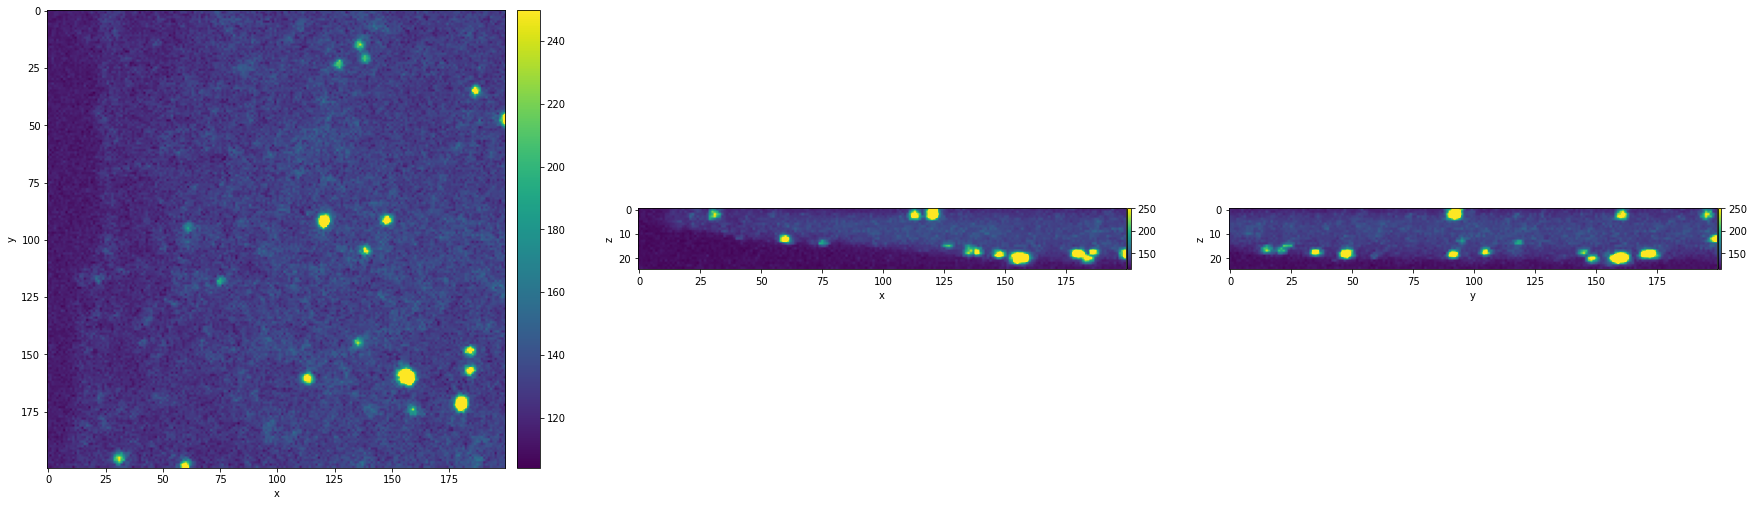

In [82]:
_ = plot_3d_projections(early[:,1,200:400,1000:1200], 'max', size=10, vmax=250)

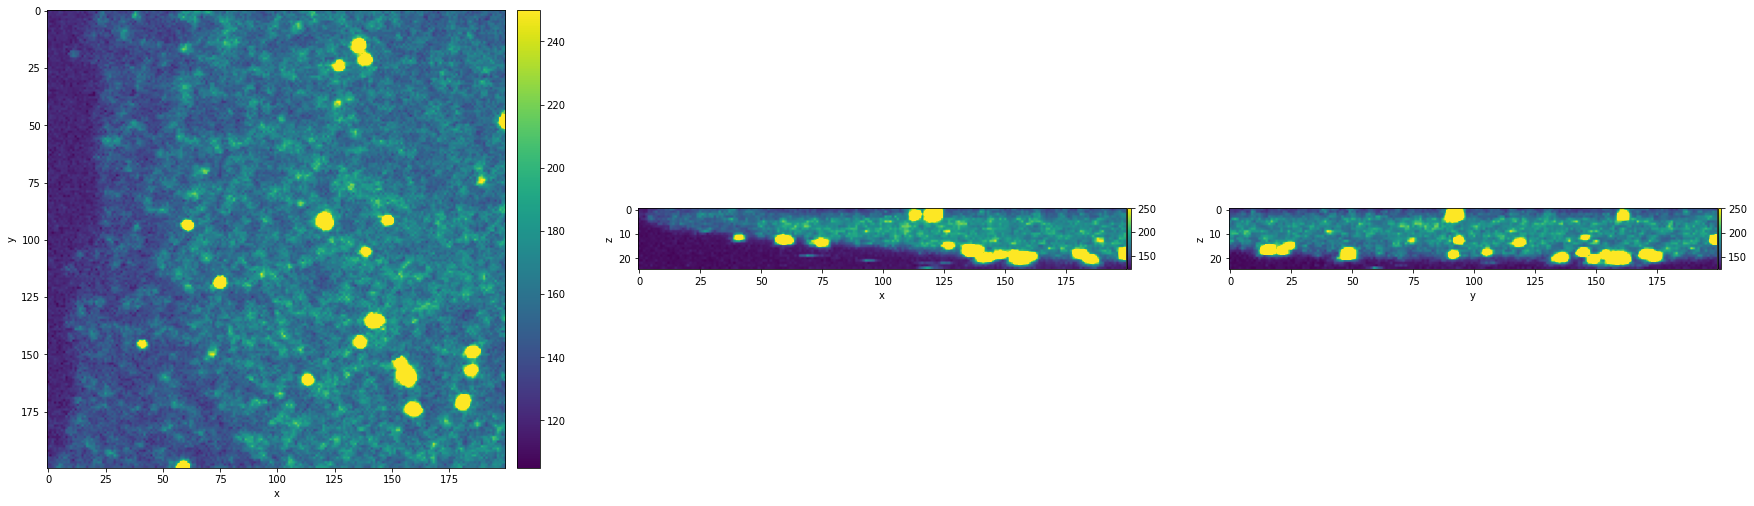

In [81]:
_ = plot_3d_projections(early[:,0,200:400,1000:1200], 'max', size=10, vmax=250)

In [76]:
ebg = hydra.utils.instantiate(cfg.bg_estimation)

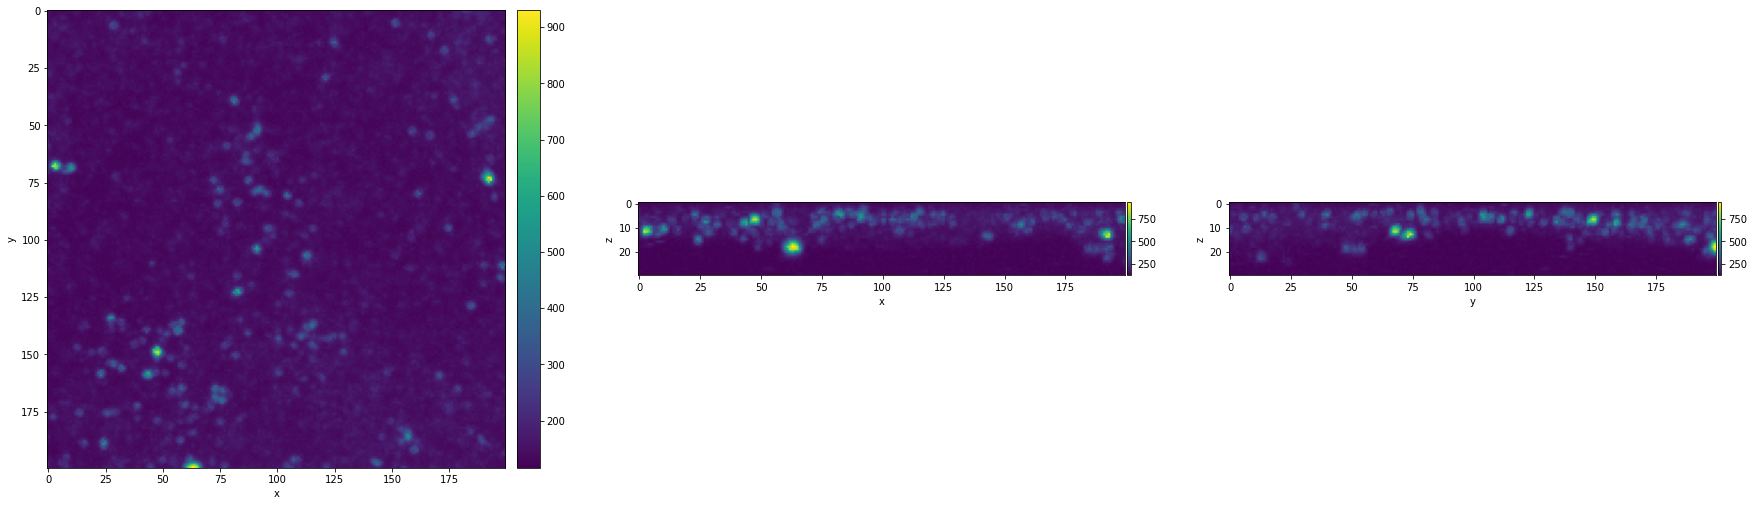

In [73]:
_ = plot_3d_projections(late[:,1,800:1000,200:400], 'max', size=10)

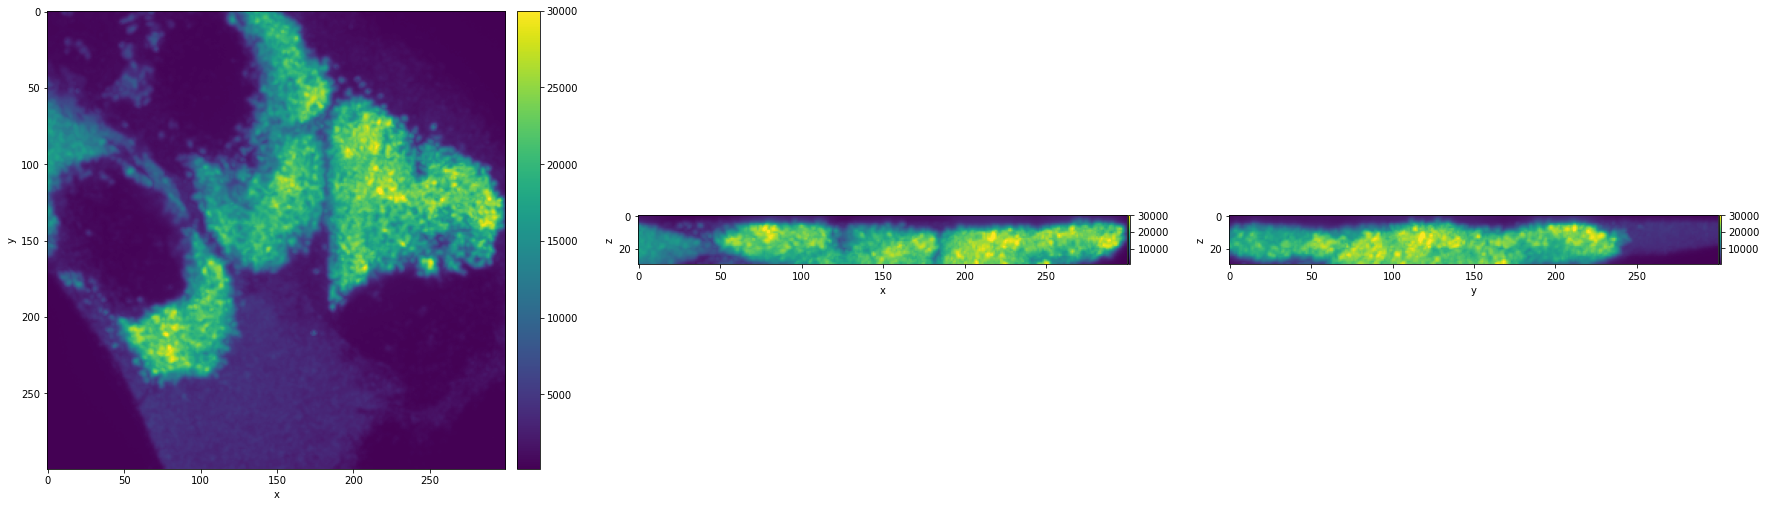

In [69]:
_ = plot_3d_projections(late[:,1,:300,:300], 'max', size=10, vmax=30000)

In [70]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [71]:
cfg.output.project = 'covid_early'

cfg.run_name ='covid_early_smFISH_7'
cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/COVID/early.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None

cfg.bg_estimation.smoothing_filter_size = 4

cfg.foci.n_foci_avg = 2
cfg.foci.n_mol_range: [3,30]

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,:,200:300,100:200]'
cfg.evaluation.px_size_zyx =  [100,100,100]

cfg.model.int_conc = 5.
cfg.model.int_rate = 1.
cfg.model.int_loc = .5
cfg.microscope.scale = 10

cfg.PSF.gauss_radii = [1.5,1.5,1.5]
cfg.PSF.psf_extent_zyx = [25,25,25]

cfg.prob_generator.low= 0.000001
cfg.prob_generator.high= 0.009

cfg.noise.theta = 2.
cfg.noise.baseline = 0.

cfg.training.num_iters = 30000
cfg.training.start_micro = 3000
cfg.training.start_psf = 3000

Store the config as an experiment

In [72]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [73]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (25, 48, 48)
1 volumes


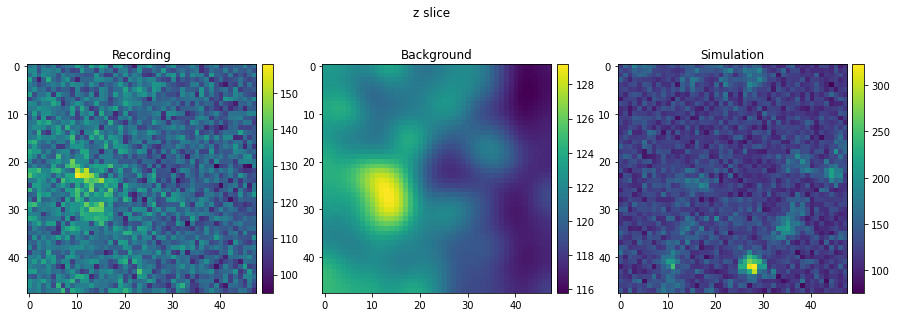

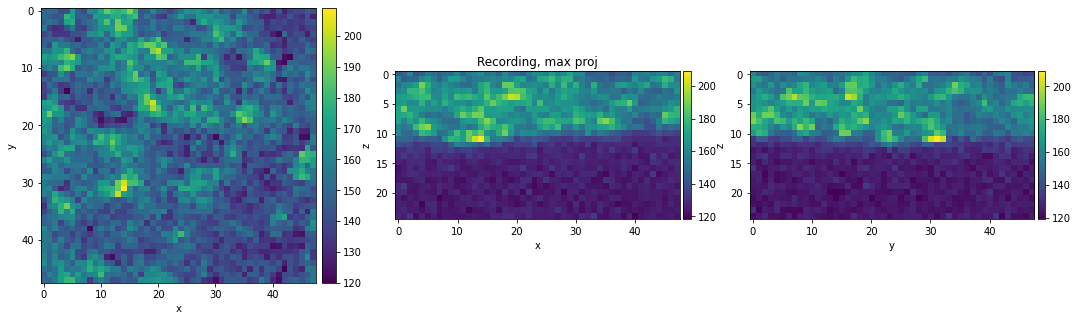

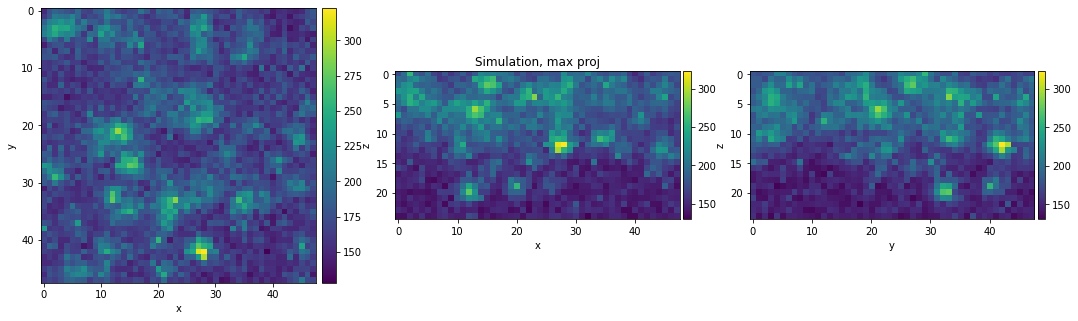

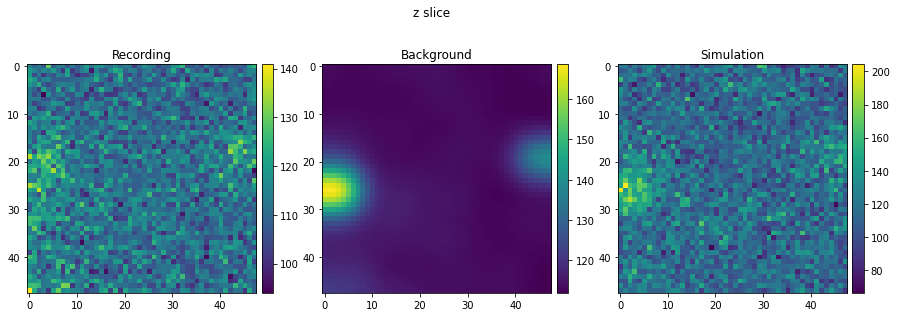

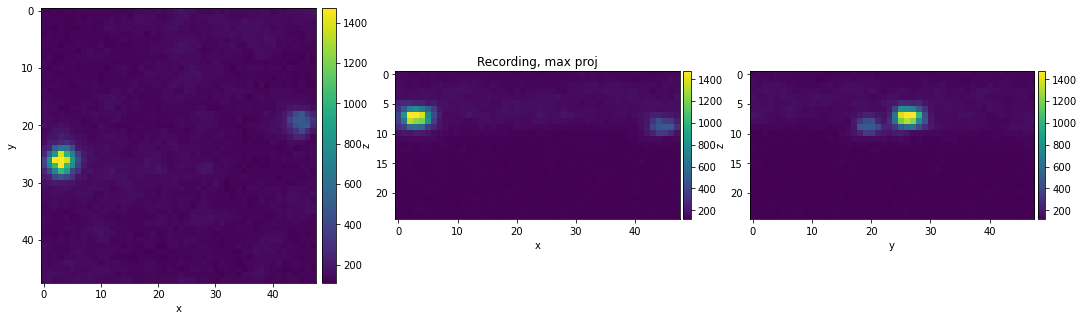

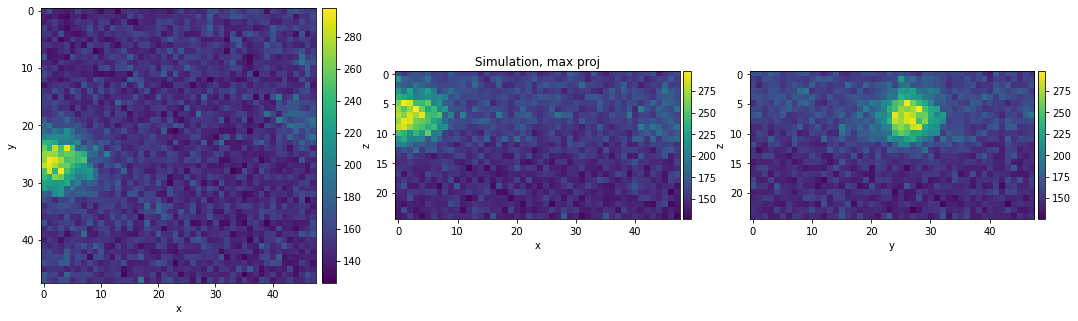

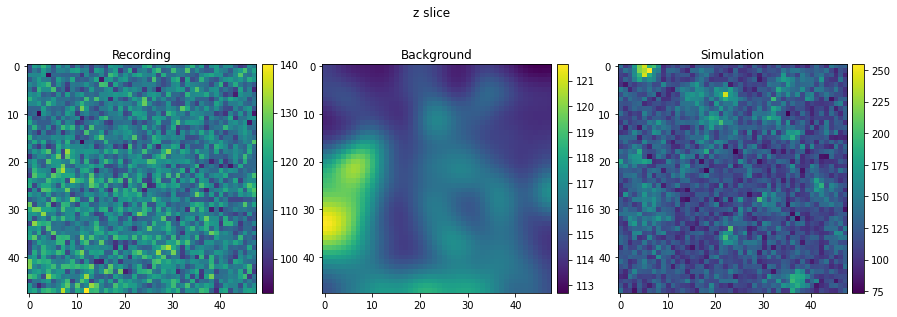

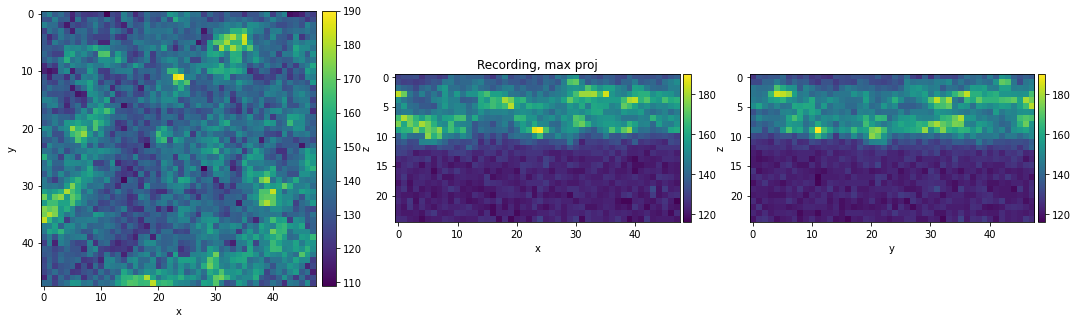

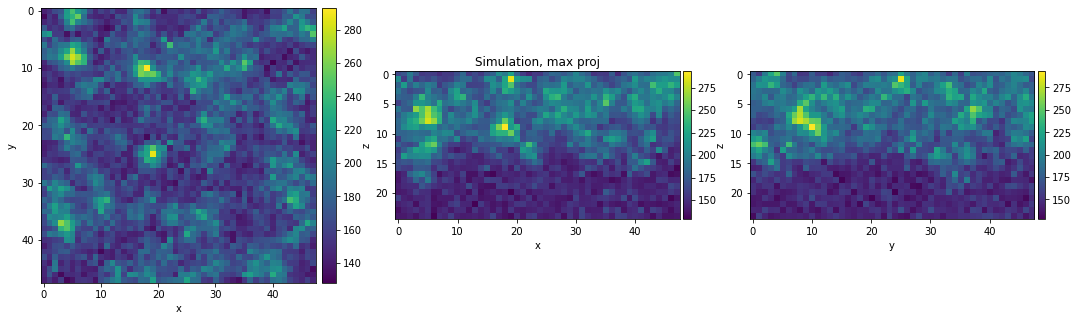

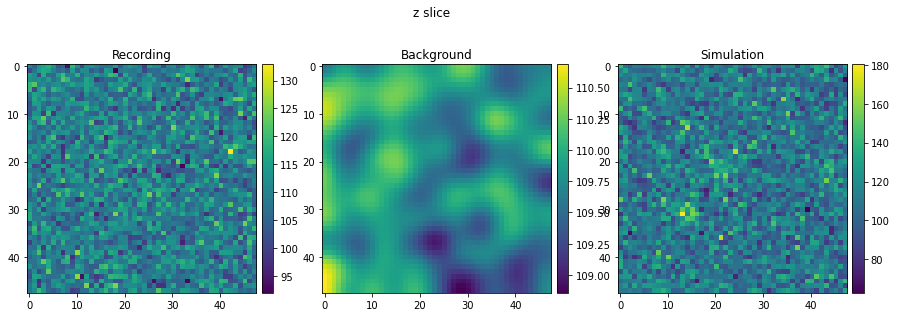

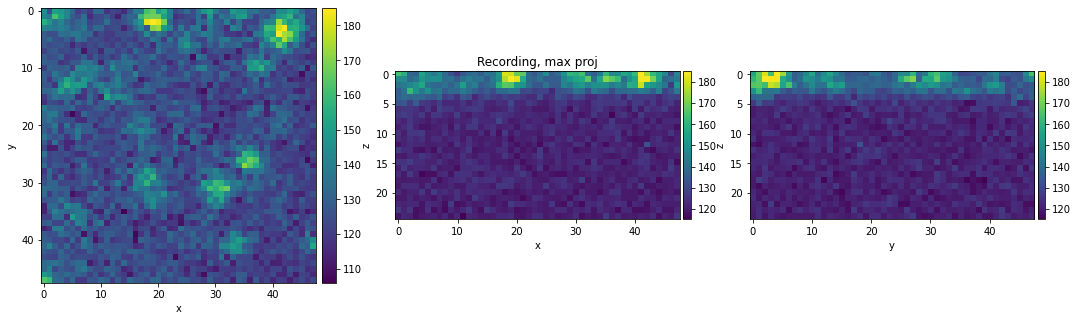

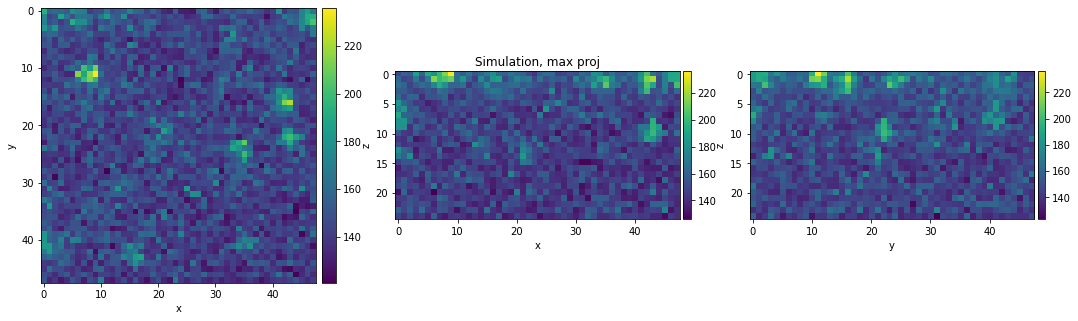

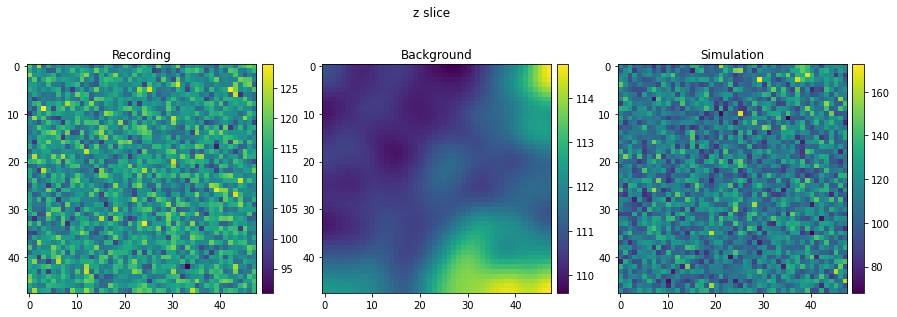

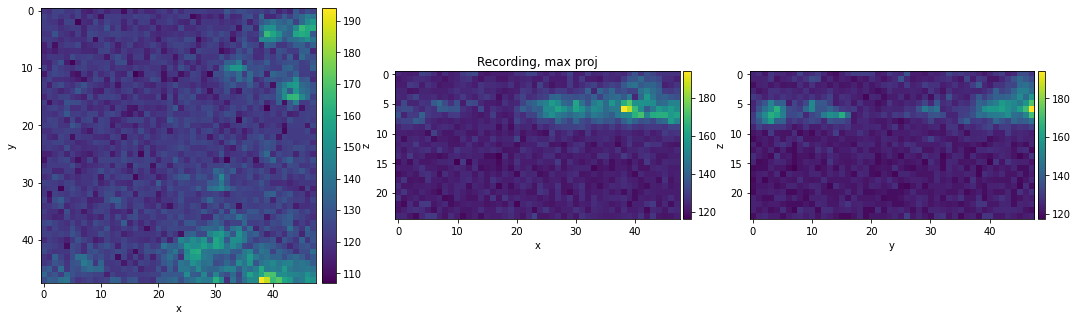

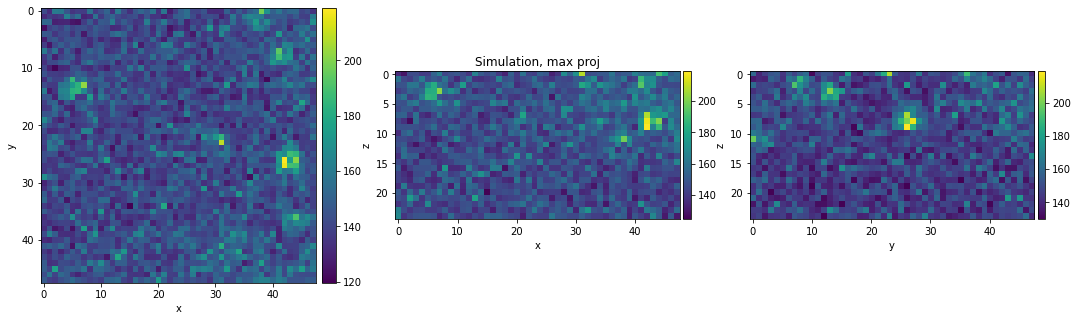

In [48]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=5)

Plot projections of the volume

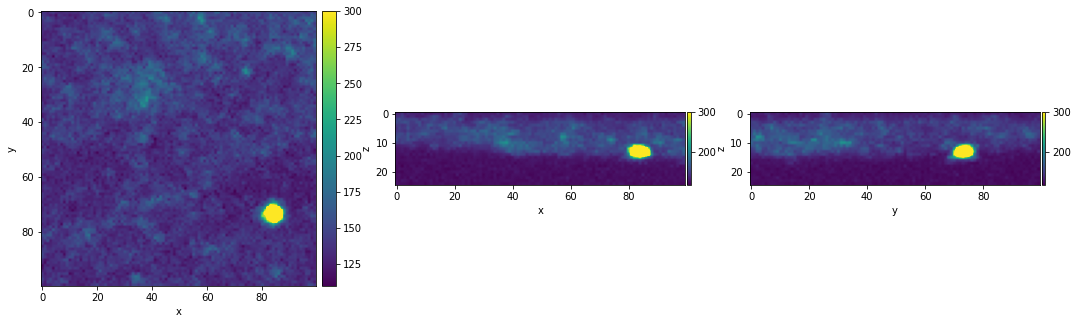

In [49]:
crop_sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img_3d[cfg.evaluation.img_ind][crop_sl[1:]], 'max', vmax=300)

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

Command to train a model on the gpu cluster

In [54]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=covid_early_smFISH_7'

# Evaluation

In [4]:
cfg = OmegaConf.load(f'config/experiment/covid_early_smFISH_7.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/covid_early//sweep_4/int_conc:5.0/train.yaml')
# cfg.run_name = 'rab11_nb'
# cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/rab11_smFISH_4.tif'


In [5]:
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(psf.psf_volume[0])

/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Crop size larger than volume in at least one dimension. Crop size changed to (25, 48, 48)
1 volumes


In [6]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (25, 48, 48)
1 volumes


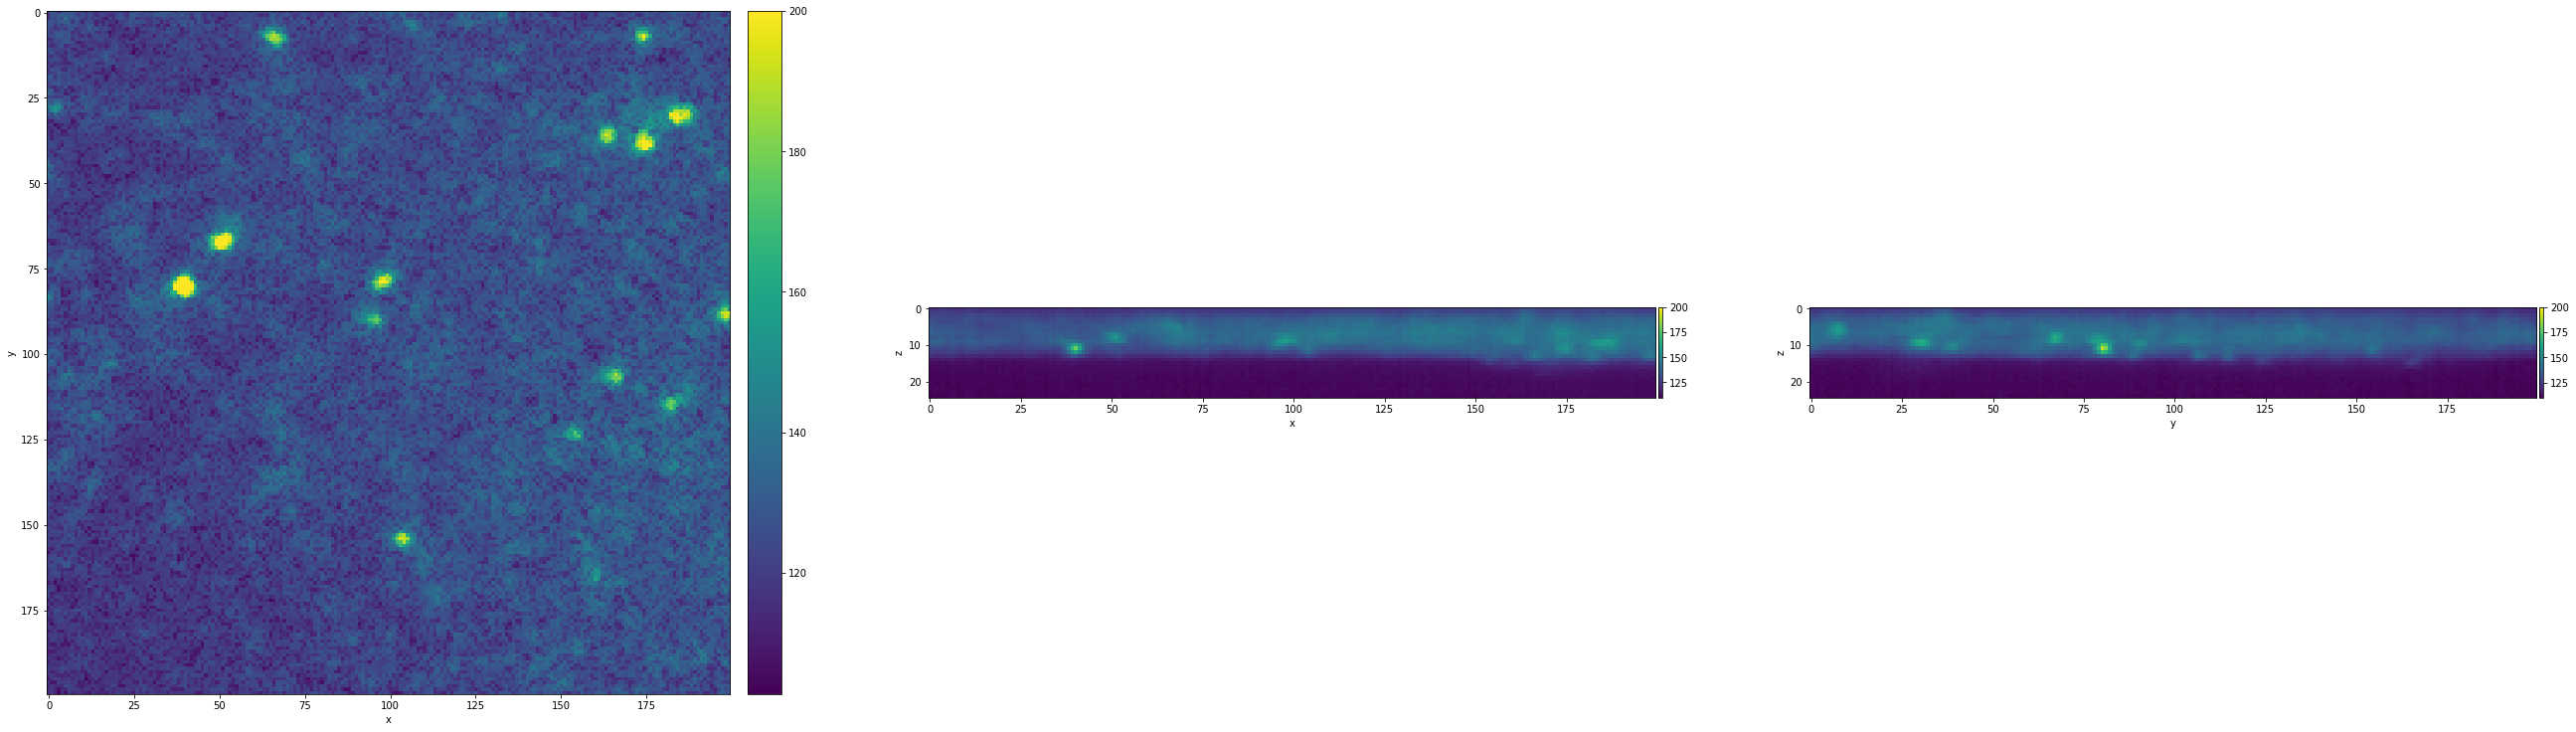

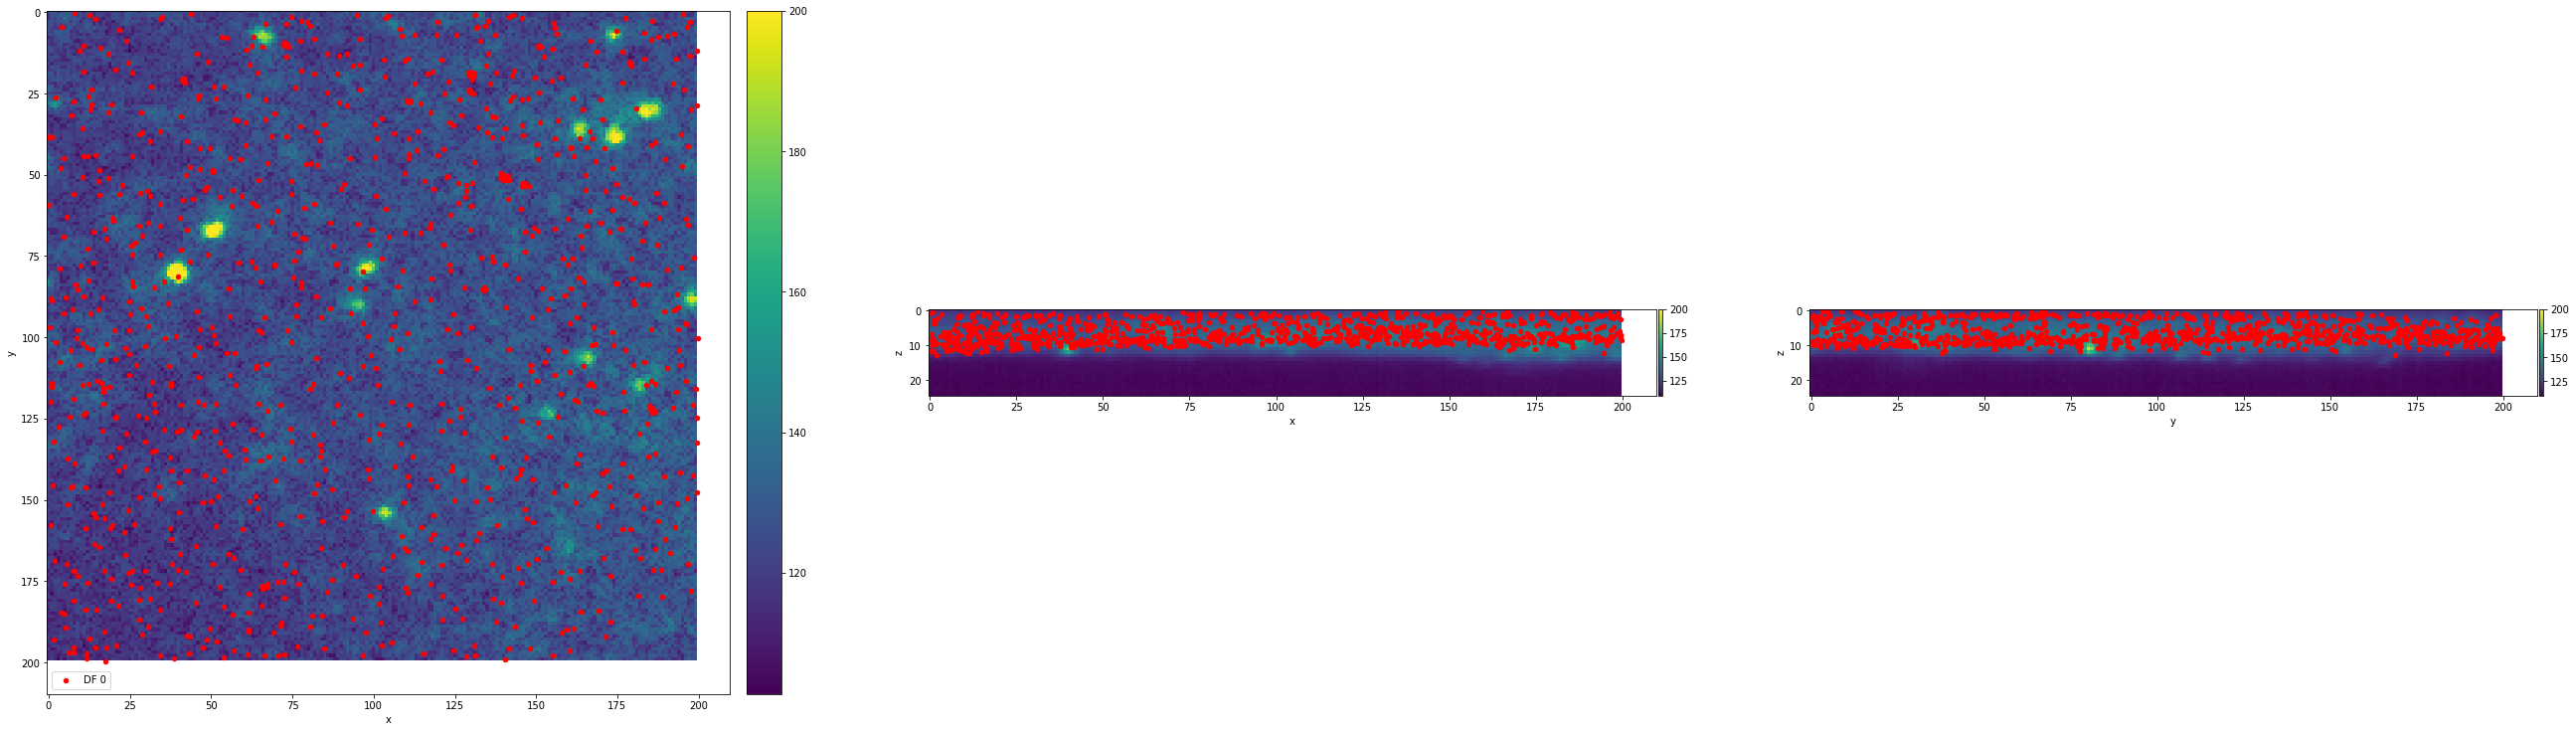

In [39]:
sl = np.s_[:,:,600:800,400:600]
axes = plot_3d_projections(img_3d[0][sl[1:]], size=15, vmax=200)

axes = plot_3d_projections(img_3d[0][sl[1:]], size=15, vmax=200)
scat_3d_projections(axes, [crop_df(pred_df, sl, px_size_zyx=[100,100,100])], px_size_zyx=[100,100,100])

(array([7.768e+03, 7.049e+03, 2.078e+03, 3.290e+02, 3.500e+01, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00]),
 array([ 2.2996879,  3.3599837,  4.4202795,  5.4805756,  6.540871 ,
         7.6011667,  8.661463 ,  9.721759 , 10.782055 , 11.84235  ,
        12.902646 ], dtype=float32),
 <BarContainer object of 10 artists>)

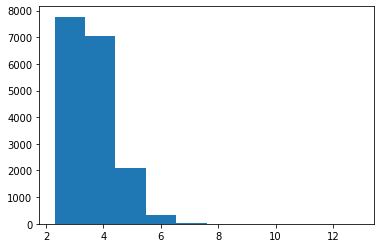

In [87]:
plt.hist(pred_df['int'])

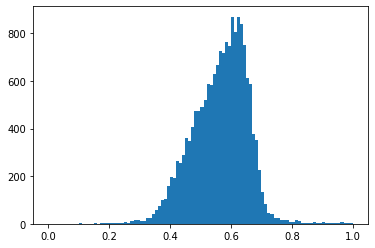

In [88]:
_=plt.hist(pred_df['comb_sig'], bins = np.linspace(0,1,101))

Plot projections of the PSF before and after optimizing it during training

(tensor(11.9999, device='cuda:0', grad_fn=<DivBackward0>), tensor(12.0018, device='cuda:0', grad_fn=<DivBackward0>), tensor(12.0008, device='cuda:0', grad_fn=<DivBackward0>))
Sum:  179.67984 53.15493
CSum:  194.91277 53.15493


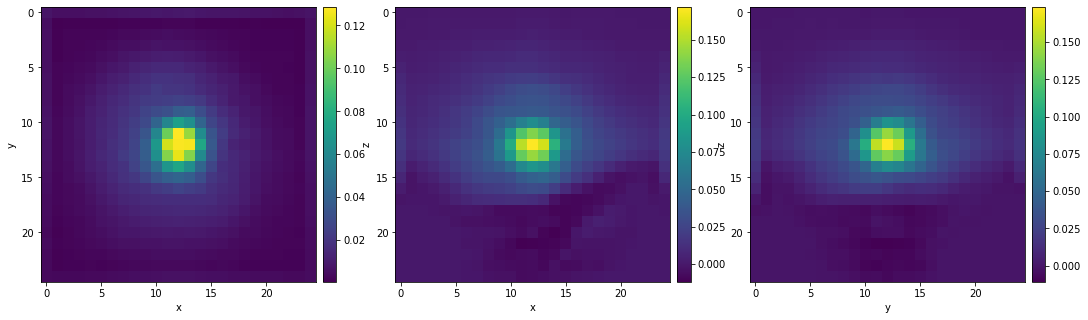

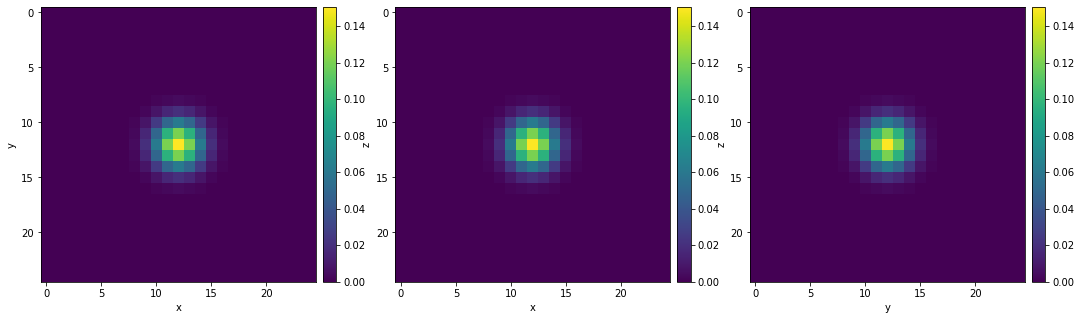

In [89]:
print(psf.get_com())
plot_3d_projections(psf_vol)
plot_3d_projections(psf_init)
print('Sum: ',  psf_vol.sum(), psf_init.sum())
print('CSum: ', np.clip(psf_vol,0,10).sum(), psf_init.sum())

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

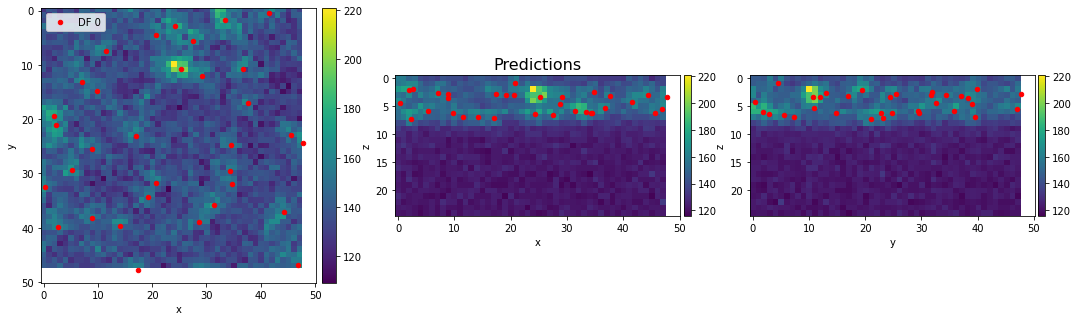

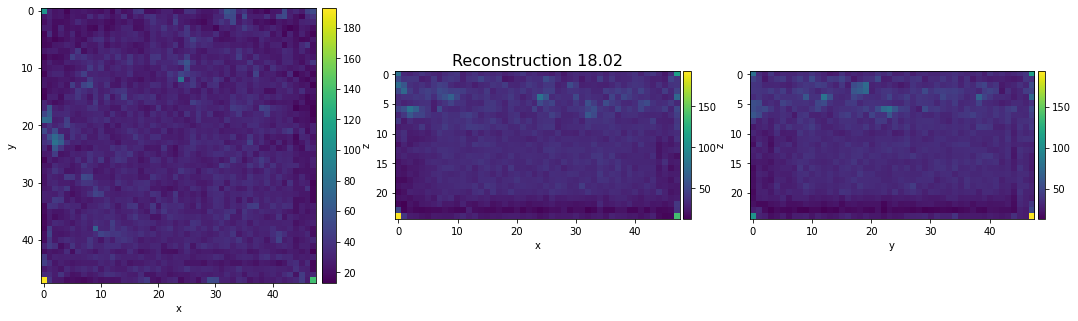

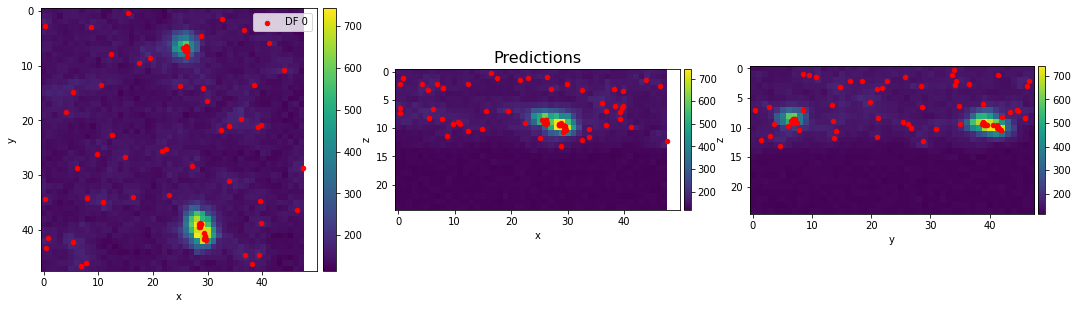

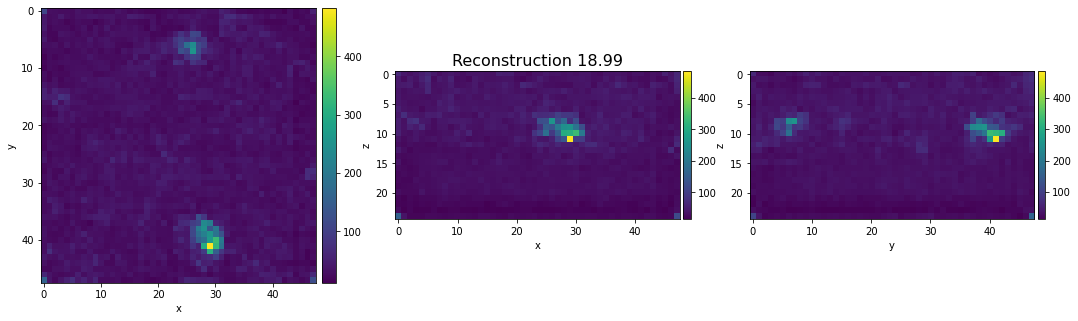

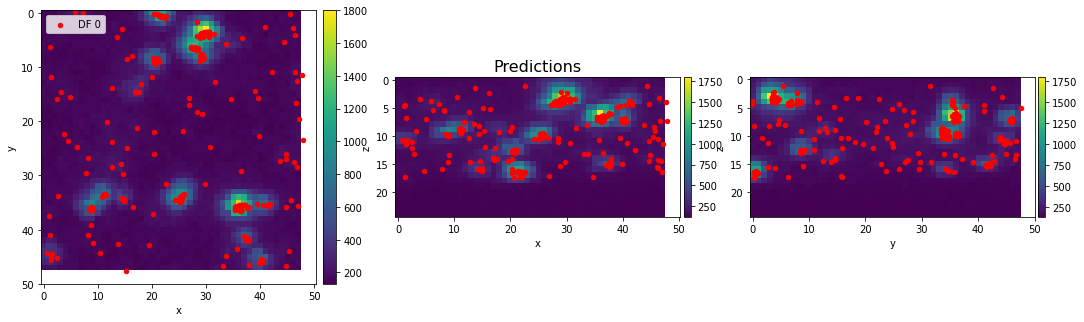

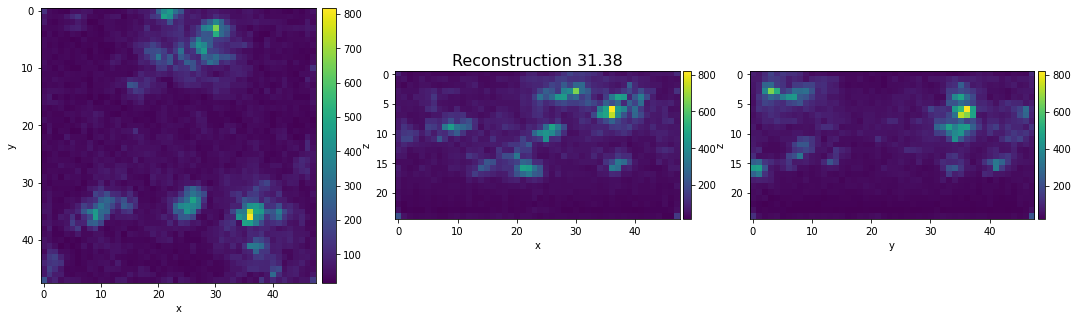

In [90]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3)

Volume with Foci? Max projection of real volume, reconstruction, difference

In [149]:
pred_df, gt_rec, res_dict = get_prediction(model,post_proc,img_3d[:,250:350,300:400], micro, return_rec=True, cuda=True, min_int=0.3)
_ = gt_plot(img_3d[:,250:350,300:400][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])
# torch.save(res_dict, 'data/model_output_r.pt')

TypeError: list indices must be integers or slices, not tuple

In [24]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[0][None,None,:,:500,:500].to('cpu'))
#     pred_df = post_proc(res)
#     free_mem()

Inferred intensities

In [27]:
xyz_arr = pred_df[['x','y','z']].values
# np.save('early_xyz',xyz_arr)

62981


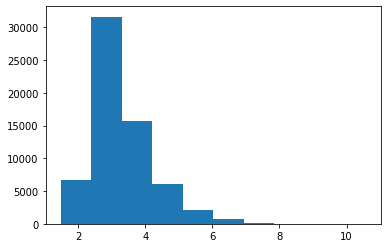

In [15]:
_ = plt.hist(pred_df['int'])
print(len(pred_df))

In [9]:
cfg.model._target_ = 'decode_fish.engine.model.InferenceNetwork'
inf_model = hydra.utils.instantiate(cfg.model)
inf_model = load_model_state(inf_model, cfg.output.save_dir, 'model.pkl')

In [10]:
from monai.inferers import sliding_window_inference

In [11]:
img_3d[0].shape

torch.Size([25, 2048, 2048])

In [12]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[0][None,None,:,:256,:256].to('cpu'))

In [27]:
with torch.no_grad():
    tra = sliding_window_inference(img_3d[0][None,None,:,:,:], [25,256,256], 2, inf_model.cuda(), overlap=0.05 ,sw_device ='cuda', device='cpu', mode='gaussian')

In [28]:
pred_df = post_proc(inf_model.tensor_to_dict(tra))
free_mem()

In [32]:
pred_df

loc_idx  frame_idx              x              y            z  \
0            0          0   68775.312500    6590.645508   104.087433   
1            1          0   68839.335938    6551.940918   126.555443   
2            2          0  132078.390625    6638.558105    -1.805443   
3            3          0  129717.093750    6838.985352    91.468559   
4            4          0  129687.429688    6780.326172    97.721848   
...        ...        ...            ...            ...          ...   
95422    95422          0   88859.476562  176440.296875  2471.558105   
95423    95423          0   89036.390625  176423.859375  2468.413818   
95424    95424          0   88849.992188  176610.265625  2521.834717   
95425    95425          0   88936.476562  176597.968750  2509.214600   
95426    95426          0   88945.085938  176604.203125  2484.828369   

           prob       int   int_sig      x_sig      y_sig      z_sig  comb_sig  
0      1.000000  3.564827  0.746226  21.532627  27.984482  42.034111  0.738254  
1      1.000000  2.484699  0.407676  43.049458  29.192814  76.357407  1.016918  
2      1.000000  2.556505  0.374146  36.452068  38.831947   9.142293  0.612446  
3      0.528083  2.598237  0.583760  25.474878  17.675833  35.179005  0.669276  
4      1.000000  2.956178  0.540574  23.096186  36.062943  48.252182  0.816038  
...         ...       ...       ...        ...        ...        ...       ...  
95422  1.000000  4.330779  0.907841  18.480265  16.129705  12.317619  0.428188  
95423  0.639790  4.014347  1.133958  14.455729  11.437433  10.751691  0.376159  
95424  1.000000  1.460914  0.183782  61.621994  37.524803  13.053618  0.806892  
95425  1.000000  2.986465  0.359422  18.152952  35.311825   7.532991  0.482675  
95426  0.830730  4.600074  1.098170  16.664972  14.907357  11.178658  0.402221  

[95427 rows x 12 columns]

In [33]:
xyz_arr = pred_df[['x','y','z']].values
np.save('data/results/early_ch0_xyz',xyz_arr)